**Image segmentation using the U-Net Model**

https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/

Annotated HDS 4/27/2023

Note that on this date, the Image Segmentation example on Tensorflow's tutorial did not work,  some sort of conflict has developed related to the image download in that tutorial

You will want the high performance GPU but not the high memory configuration to run this notebook


**U-Net**

This uses a U-net model for *semantic segmentation* in which each pixel is outside the object, in the object or on the border

This is an encoder-decoder style network,  it compresses the information into a small image and then expands it again

The encoder is a set of convolutional filters with pooling and skip connections

There is a *bridge* structure between the encoder and decoder

The decoder translates the encode information back to  a full size image that has the outline in it.

The error function is a cross entropy measure, used to compare the output to the desired target mask for the system

**Segmentation**

This is a computer vision task, in which we want to find the boundary around a specific object (a cat or dog in this case) within an image

This would allow a computer to locate specific objects in an image,   Tesla is using some variation on this in the self-driving car systems they are working on.

We have an image and the annotated outline created by a human that we will use to train a neural net to carry out image segmentation.

This is a form called *semantic segmentation*,  labeling each pixel 

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

The datset in use here is the Oxford -IIIT Pet dataset

https://www.robots.ox.ac.uk/~vgg/data/pets/

This is a set of annotated pictures of pets, in which the pet in the picture has been outlined by a human annotator.    The dataset has the original picture plus the annotation for each picture



In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [4]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    sp

We are going to resize these pictures and images, so here is a definition of a resize function

In [5]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return input_image, input_mask

Define a function to augment both the image and the mask

In [6]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask

In [ ]:
Define a function to normalize the image

In [7]:
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

we have functions to load training and test image

the training images are loaded, resized, augmented and normalized

test images are not augmented


In [76]:
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask
def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask

Map the load function over the train and test sets

In [9]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

Set up the training process

In [10]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

**Plotting an example input image and the target mask**

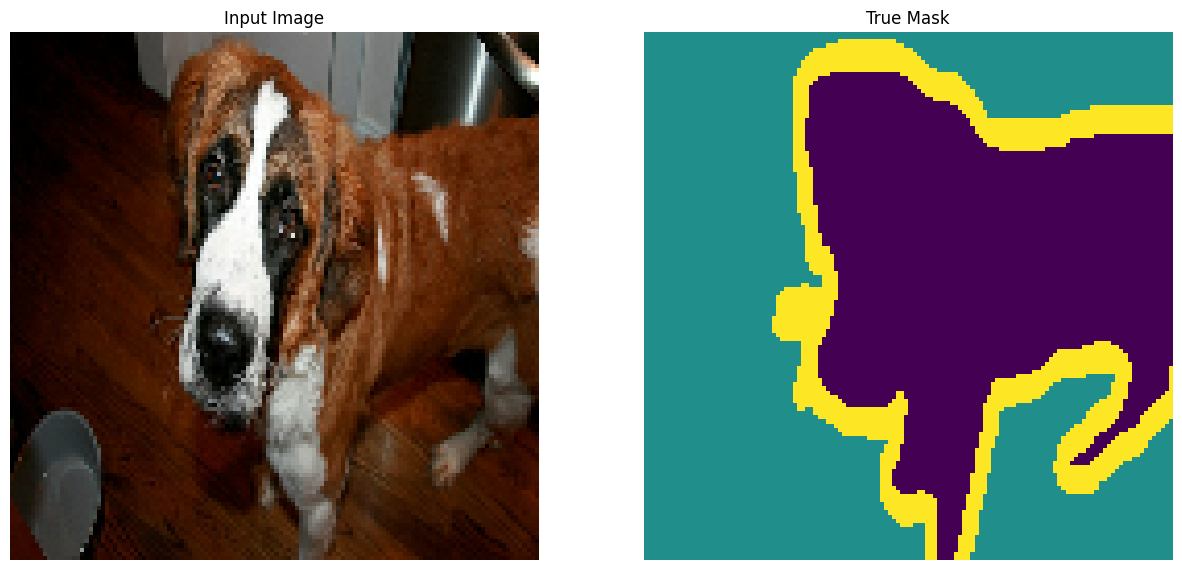

In [11]:
def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

define some structures to be used in the model construction, pairs of filters and then a pooling layer with dropout

In [12]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

In [13]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

In [14]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p

This is an up convolution layer, that expands a compressed image to a larger size,

In [15]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

Model Construction

-Input layer to handle 128 x 128 x 3 images

-A set of convolution, compression and dropout layers in the encoder

-The bottleneck layer is the bridge, this is the miniumum information level

-We then create the decoder which expands the data upward

-The output layer is itself a convolution of three filters each of size 1, so this is creating an output image,  note the softmax so we have 3 categories of values

Note: the high similarity here to an anomaly detector created with an encoder/decoder pair

In [16]:
def build_unet_model(): 
  # inputs
   inputs = layers.Input(shape=(128,128,3))

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)

   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

In [17]:
unet_model = build_unet_model()

In [18]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

This is a slow calculation,  using the standard GPU and memory it was 120 seconds per epoch

with the higher perf GPU and memory, it looks like 26 seconds per epoch after the first one, which is slower

You may want to run this for 10 epochs,  it had reached over 80% accuracy after
10 epochs

After 20 epochs it reached 86% cross validation accuracy,  

In [19]:
NUM_EPOCHS = 20

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

Epoch 1/20
57/57 [==============================] - 53s 455ms/step - loss: 0.9842 - accuracy: 0.5730 - val_loss: 0.9158 - val_accuracy: 0.5865
Epoch 2/20
57/57 [==============================] - 26s 400ms/step - loss: 0.8148 - accuracy: 0.6280 - val_loss: 0.6953 - val_accuracy: 0.7145
Epoch 3/20
57/57 [==============================] - 23s 403ms/step - loss: 0.6782 - accuracy: 0.7233 - val_loss: 0.6509 - val_accuracy: 0.7368
Epoch 4/20
57/57 [==============================] - 22s 393ms/step - loss: 0.6241 - accuracy: 0.7480 - val_loss: 0.6003 - val_accuracy: 0.7556
Epoch 5/20
57/57 [==============================] - 23s 406ms/step - loss: 0.5814 - accuracy: 0.7671 - val_loss: 0.5525 - val_accuracy: 0.7814
Epoch 6/20
57/57 [==============================] - 22s 384ms/step - loss: 0.5385 - accuracy: 0.7870 - val_loss: 0.4895 - val_accuracy: 0.8104
Epoch 7/20
57/57 [==============================] - 22s 397ms/step - loss: 0.4905 - accuracy: 0.8080 - val_loss: 0.4746 - val_accuracy: 0.8153

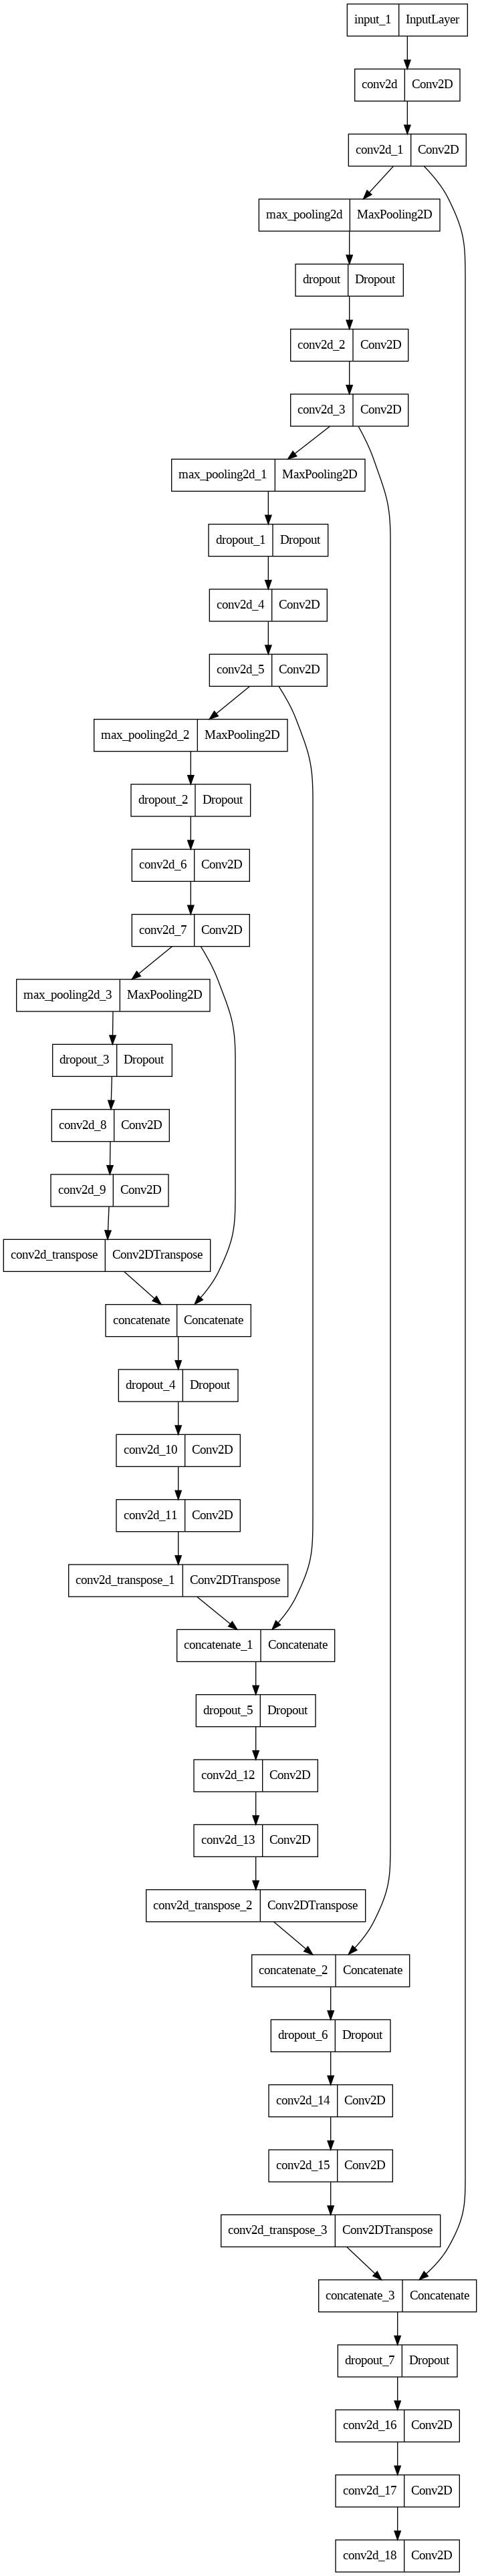

In [78]:
from tensorflow.keras.utils import plot_model
plot_model(unet_model)

Create a function to show some images, and the real and predicted segments

In [69]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [72]:
count = 0
for i in test_batches:
    count +=1
print("number of batches:", count)

number of batches: 11


2/2 [==============================] - 0s 42ms/step


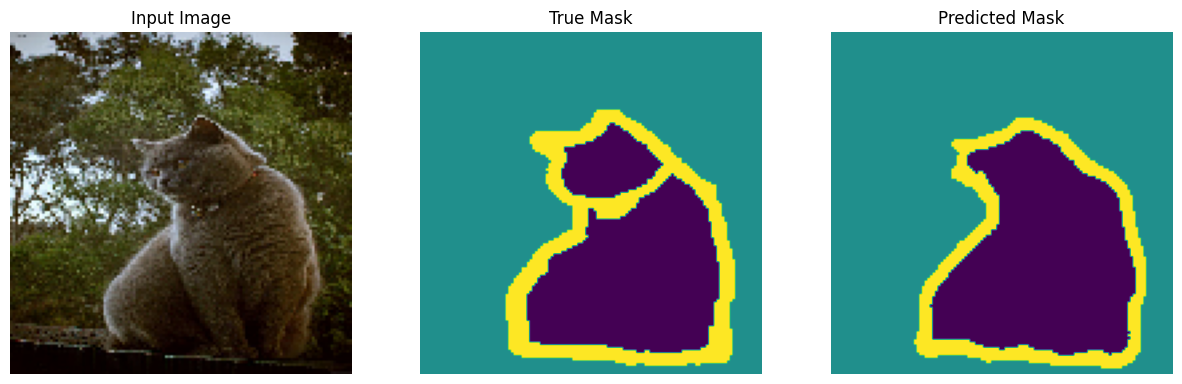

2/2 [==============================] - 0s 37ms/step


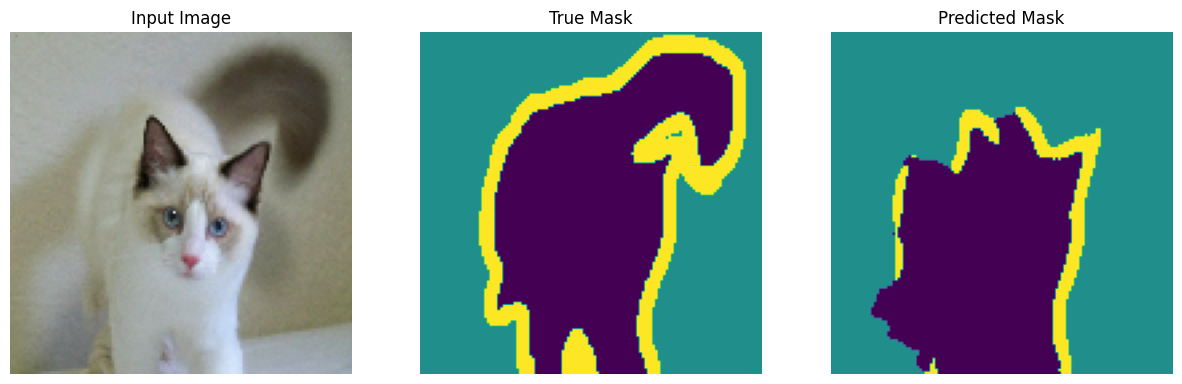

2/2 [==============================] - 0s 38ms/step


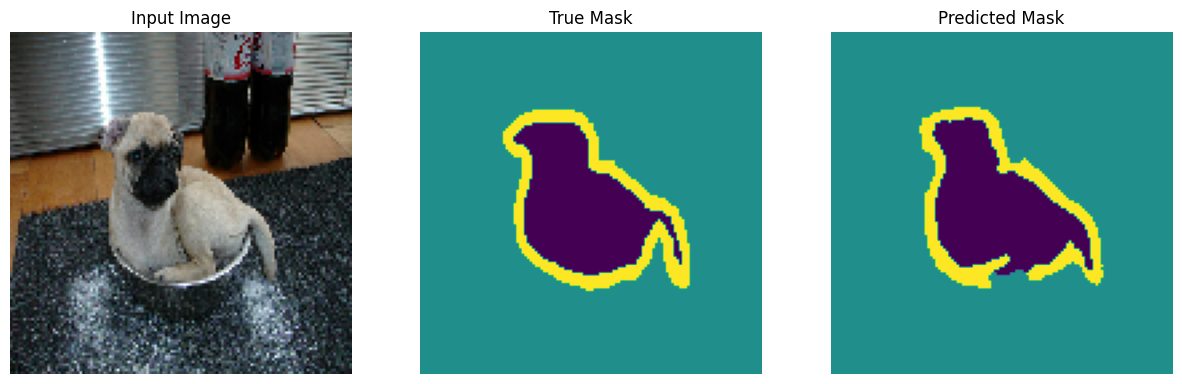

In [75]:
show_predictions(test_batches.skip(2), 3)